In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import h5py
import pandas as pd

from tqdm import tqdm_notebook as tqdm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)
plt.jet()

classes = np.array(['Peaks','Filaments','Sheets','Voids'])

<Figure size 1080x360 with 0 Axes>

In [2]:
path = './data/'

### Sci-kit learn packages

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
import pickle

### Evaluating with the example test mock // Using the environment

In [4]:
#------------ Reading Bsk features catalog
filename = path+'example_features.hdf5' # Filename with the features for the model
f = h5py.File(filename, 'r')
headers = list(f.keys())
print(headers)
ID = np.array(f['ID'])
nc = np.array(f['nc'])
ad = np.array(f['ad'])
mr = np.array(f['mr'])
den = np.array(f['den'])
Dnc = np.array(f['Dnc'])
Dad = np.array(f['Dad'])
Dmr = np.array(f['Dmr'])
Dden = np.array(f['Dden'])
f.close()

#------------ Reading the mock catalog to extract environments and positions   
filename = path+'example_test_mock.hdf5'
f = h5py.File(filename, 'r')
headers=list(f.keys())
env_pot = np.array(f['environment']) # 3 void, 2 sheet, 1 filament, 0 peak
x = np.array(f['x'])
y = np.array(f['y']) 
z = np.array(f['z'])
f.close()

classes = np.array(['Peaks','Filaments','Sheets','Voids'])
np.set_printoptions(precision=4)
       
#------------ Defining the features space 
Xdata = pd.DataFrame({'ad':ad,'nc':nc,'mr':mr,'den':den,'Dad':Dad,'Dnc':Dnc,'Dmr':Dmr,'Dden':Dden}) #
Ydata = pd.DataFrame({'env':env_pot})

Posdata = pd.DataFrame({'x':x,'y':y, 'z':z})

['Dabc', 'Dad', 'Dden', 'Dmr', 'Dnc', 'ID', 'abc', 'ad', 'con', 'coor', 'den', 'mr', 'nc', 'vol']


RandomForestClassifier(max_depth=10, n_estimators=80)


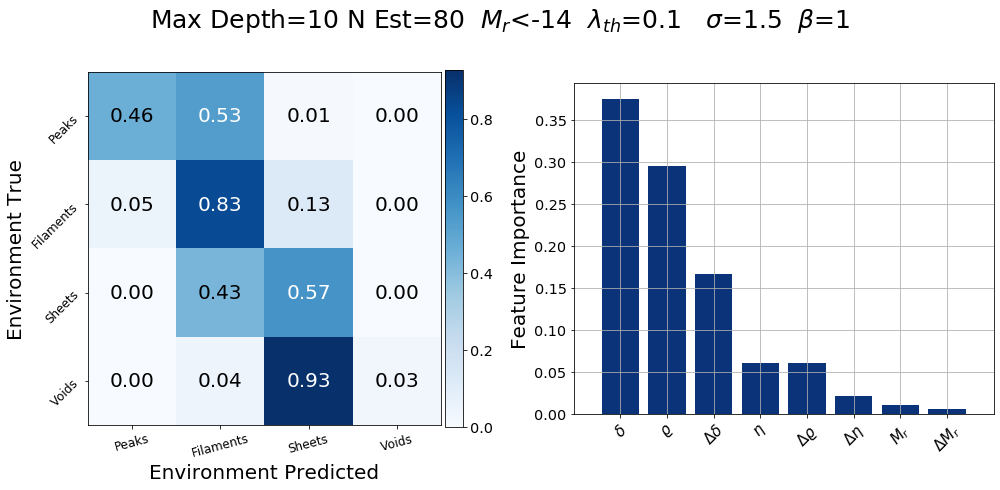

In [5]:
fig= plt.figure(figsize=(14,7))

#------------ Loading the model
clf = pickle.load(open(path+'cosmicweb_bsk_model.sav','rb'))
print(clf)

Ypred = clf.predict(Xdata)


#------------ Confusion Matrix
cm = confusion_matrix(Ydata, Ypred)
classes = classes[unique_labels(Ydata, Ypred)]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = fig.add_subplot(1,2,1)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.74)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Environment Predicted",size=20)
ax.set_ylabel("Environment True",size=20)
ax.set_ylim(4-0.5, -0.5)

plt.setp(ax.get_xticklabels(), rotation=15, size=12)
plt.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

#------------ Feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
lfi=len(importances)
features=np.array(list(['ad','nc','mr','den','Dad','Dnc','Dmr','Dden']))
features_tex=["$\delta$","$\eta$","$M_{r}$",r'$\varrho$',"$\Delta \delta$","$\Delta \eta$","$\Delta M_{r}$",r'$\Delta \varrho$']


#------------ Plot the feature importances
ax = fig.add_subplot(1,2,2,aspect=18,rasterized=True)
plt.bar(range(lfi), importances[indices], color="#0a337a", align="center")
plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
plt.grid()
plt.ylabel("Feature Importance",size=20)
plt.xlim([-1, lfi])

fig.suptitle('Max Depth=10 N Est=80  $M_{r}$<-14  $\lambda_{th}$=0.1   $\sigma$=1.5  $\\beta$=1',size=25)
fig.subplots_adjust(top=0.97)
fig.tight_layout()

plt.savefig('./figures/evaluation.png', bbox_inches='tight', resterized=True, transparent=True)
plt.show()